In [1]:
!pip install opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 18.5 MB/s eta 0:00:00


In [2]:
import cv2
from google.colab.patches import cv2_imshow
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


- test code에서 label을 주지 않고 사진만 넣어서 예측하게 해보기

# CNN

In [4]:
import os
from PIL import Image
import json

class TicTacToeCellDataset:
    def __init__(self, image_dir, label_dir, transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.image_paths = []
        self.labels_paths = []

        # 이미지와 라벨 경로 확인
        image_files = [f for f in os.listdir(image_dir) if f.endswith(('.jpg', '.JPG'))]
        label_files = [f for f in os.listdir(label_dir) if f.endswith(('.json'))]

        # 이미지와 라벨 경로 설정
        for image_file in image_files:
            image_path = os.path.join(image_dir, image_file)
            label_filename = os.path.splitext(image_file)[0] + '_labels.json'
            label_path = os.path.join(label_dir, label_filename)  # 라벨 경로 설정
            if os.path.exists(label_path):
                self.image_paths.append(image_path)
                self.labels_paths.append(label_path)

        # 데이터셋의 길이 출력
        print(f"Found {len(self.image_paths)} images and {len(self.labels_paths)} labels.")

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label_path = self.labels_paths[idx]

        # 이미지 로드
        image = Image.open(image_path).convert('RGB')

        # 라벨 로드
        with open(label_path, 'r') as f:
            label_data = json.load(f)

        # 'O' -> 1, 'X' -> -1, 'blank' -> 0
        label_mapping = {'O': 0, 'X': 1, 'blank': 2}
        # label_data의 각 셀을 숫자로 변환
        label_tensor = torch.tensor([label_mapping[label_data[f'cell_{i}']] for i in range(9)], dtype=torch.float32)

        # 변환 적용 (이미지 텐서로 변환)
        if self.transform:
            image = self.transform(image)

        return image, label_tensor

In [73]:
import torch.nn as nn
import torch.nn.functional as F

class TicTacToeCNN(nn.Module):
    def __init__(self):
        '''
        hint: convoluation layer, batch normalization, dropout, fully connected 사용
        '''
        # 여기에 코드 작성해주세요
        super(TicTacToeCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.batchnorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.batchnorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.batchnorm3 = nn.BatchNorm2d(128)
        # 추가레이어
        # self.conv4 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        # self.batchnorm4 = nn.BatchNorm2d(256)


        self.fc1 = nn.Linear(128*4*4, 128)
        self.fc2 = nn.Linear(128, 27)
        # 여기에 코드 작성해주세요  # O, X, blank (3 classes)

    def forward(self, x):
        # 여기에 코드 작성해주세요
        x = F.relu(self.batchnorm1(self.conv1(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.batchnorm3(self.conv3(x)))
        x = F.max_pool2d(x, 2)
        # x= F.relu(self.batchnorm4(self.conv4(x)))
        # x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        x = self.fc2(x)
        x= x.view(-1,9,3)

        return x

In [12]:
!unzip -q /content/image_black-20260220T093219Z-1-001.zip -d ./my_images
!unzip -q /content/labels-20260220T093230Z-1-001.zip -d ./my_labels

unzip:  cannot find or open /content/image_black-20260220T093219Z-1-001.zip, /content/image_black-20260220T093219Z-1-001.zip.zip or /content/image_black-20260220T093219Z-1-001.zip.ZIP.
unzip:  cannot find or open /content/labels-20260220T093230Z-1-001.zip, /content/labels-20260220T093230Z-1-001.zip.zip or /content/labels-20260220T093230Z-1-001.zip.ZIP.


Found 40 images and 40 labels.
Epoch 1/10, Loss: 1.1645
Epoch 2/10, Loss: 0.9250
Epoch 3/10, Loss: 0.7863
Epoch 4/10, Loss: 0.6677
Epoch 5/10, Loss: 0.5552
Epoch 6/10, Loss: 0.4479
Epoch 7/10, Loss: 0.3592
Epoch 8/10, Loss: 0.2595
Epoch 9/10, Loss: 0.1898
Epoch 10/10, Loss: 0.1371


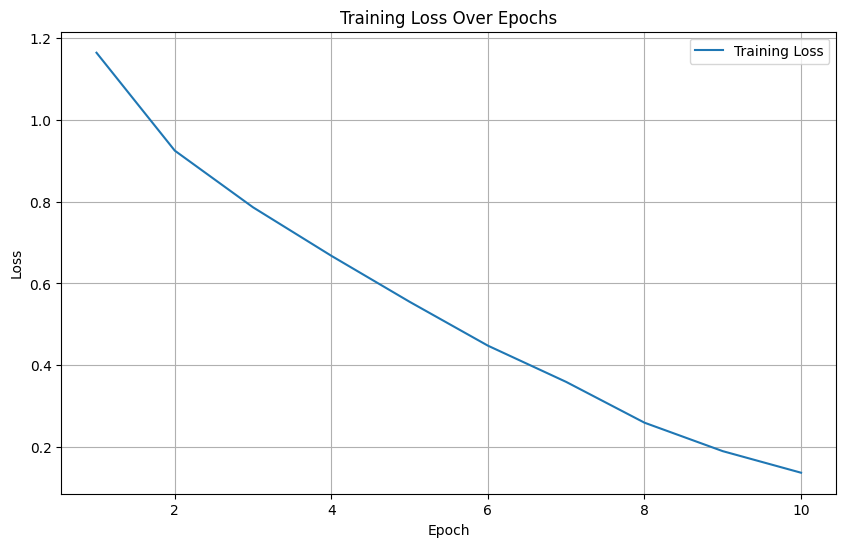

In [76]:
from IPython.core import history
from torch.utils.data import DataLoader
from torchvision import transforms
import torch
import torch.optim as optim

# 데이터셋 및 데이터로더
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32))
])

dataset = TicTacToeCellDataset(image_dir='/content/my_images/image_black', label_dir='/content/my_labels/labels', transform=transform)
dataloader = DataLoader(dataset, batch_size=8, shuffle=True)
# 여기에 코드 작성해주세요(단, batch_size=8로 설정할 것)

##모델 선언 및 손실 함수, 최적화 도구 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TicTacToeCNN().to(device)
# 여기에 코드 작성해주세요
criterion = nn.CrossEntropyLoss() # 정답과 예측값 차이를 계산
# 여기에 코드 작성해주세요
optimizer = optim.Adam(model.parameters(), lr=0.001) # 가중치를 업데이트하는 도구
# 여기에 코드 작성해주세요

# 학습 루프
loss_history=[]
epochs=10

for epoch in range(epochs):
    running_loss=0.0
    for images, labels in dataloader:
        # 데이터를 GPU/CPU로 보냄
        images= images.to(device)
        # labels의 차원을 맞추고 데이터 타입을 정수형(long)으로 변환
        # .view(-1)은 데이터를 1차원으로 길게 늘려주는 역할
        labels= labels.to(device).long().view(-1)

        # 기울기 초기화
        optimizer.zero_grad()

        # 모델에 이미지 입력 (forward)
        outputs= model(images)

        # 손실 계산
        loss= criterion(outputs.view(-1,3), labels)

        # 역전파 수행
        loss.backward()

        # 가중치 업데이트
        optimizer.step()

        # 손실 누적
        running_loss += loss.item()

    # 에폭마다 평균 Loss 저장
    epoch_loss= running_loss/len(dataloader)
    loss_history.append(epoch_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {epoch_loss:.4f}")



# 여기에 코드 작성해주세요
'''
hint: loss 그래프를 출력할 수 있도록 for loop가 돌아가기 전 loss_history=[] 만들기
      loss 출력값 확인해보는 것도 좋습니다.
'''
# 여기에 코드 작성해주세요


plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), loss_history, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Validation ver.

Found 40 images and 40 labels.
Epoch 1/50, Training Loss: 1.1096837520599365, Validation Loss: 1.101433277130127
Epoch 2/50, Training Loss: 1.0404361486434937, Validation Loss: 1.0981699228286743
Epoch 3/50, Training Loss: 0.8591684699058533, Validation Loss: 1.0949344635009766
Epoch 4/50, Training Loss: 0.8133840560913086, Validation Loss: 1.0893746614456177
Epoch 5/50, Training Loss: 0.7664404511451721, Validation Loss: 1.0849430561065674
Epoch 6/50, Training Loss: 0.7134928703308105, Validation Loss: 1.0842375755310059
Epoch 7/50, Training Loss: 0.6590675115585327, Validation Loss: 1.08786940574646
Epoch 8/50, Training Loss: 0.6100940704345703, Validation Loss: 1.0917378664016724
Epoch 9/50, Training Loss: 0.5658189058303833, Validation Loss: 1.0922662019729614
Epoch 10/50, Training Loss: 0.5186922550201416, Validation Loss: 1.0908516645431519
Epoch 11/50, Training Loss: 0.4728275537490845, Validation Loss: 1.0910619497299194
Epoch 12/50, Training Loss: 0.4261671304702759, Validatio

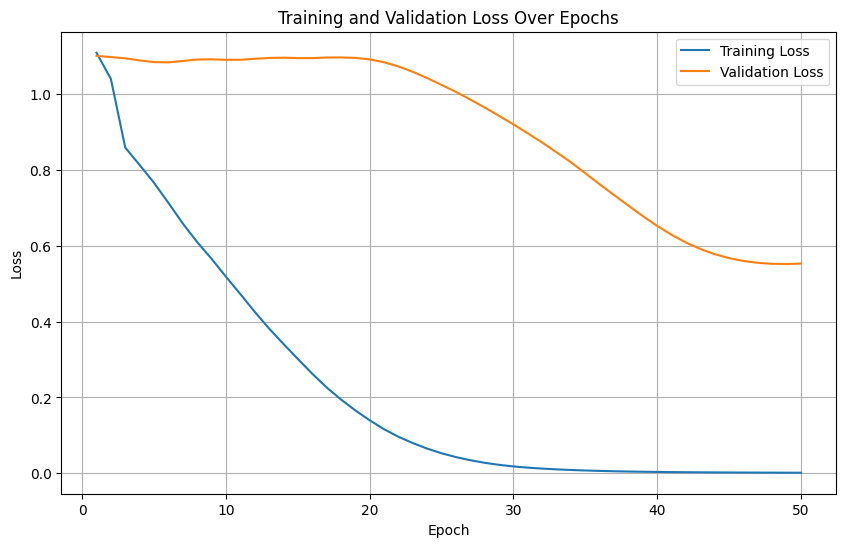

In [77]:
from math import e
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from torchvision import transforms
import torch

# 데이터셋 및 데이터로더
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((32,32))
])


dataset = TicTacToeCellDataset(image_dir= '/content/my_images/image_black',
                                label_dir= '/content/my_labels/labels',
                                transform=transform)

# train, test split
train_dataset, val_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
# 여기에 코드 작성해주세요(단, random_state=42로 설정)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# 여기에 코드 작성해주세요(단, batch_size=32로 설정)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)
# 여기에 코드 작성해주세요(단, batch_size=32로 설정)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TicTacToeCNN().to(device)
# 여기에 코드 작성해주세요
criterion = nn.CrossEntropyLoss() # 정답과 예측값 차이를 계산
# 여기에 코드 작성해주세요
optimizer = optim.Adam(model.parameters(), lr=0.001) # 가중치를 업데이트하는 도구
# 여기에 코드 작성해주세요

# 학습 루프
# 1. train 단계
# 여기에 코드 작성해주세요

train_loss_history = []
val_loss_history = []
epochs=50
for epoch in range(epochs):
    model.train() # 학습모드
    running_train_loss=0.0

    for images, labels in train_dataloader:
        images= images.to(device)
        labels= labels.to(device).long()

        optimizer.zero_grad() # 기울기 초기화
        outputs= model(images) # 예측

        ## 모양변경
        outputs= outputs.view(-1,3)
        labels= labels.view(-1)

        loss= criterion(outputs, labels) # 손실 계산
        loss.backward() # 역전파
        optimizer.step() # 가중치 업데이트

        running_train_loss += loss.item()

    epoch_train_loss= running_train_loss/len(train_dataloader)
    train_loss_history.append(epoch_train_loss)

    # 2. Validation 단계
    model.eval()
    # 여기에 코드 작성해주세요
    running_val_loss=0.0
    with torch.no_grad(): # 기울기 계산을 하지 않고 메모리 절약
        for images, labels in val_dataloader:
            images= images.to(device)
            labels= labels.to(device).long()

            outputs= model(images)

            ##모양 변경
            outputs_view= outputs.view(-1,3)
            labels_view= labels.view(-1)
            loss= criterion(outputs_view, labels_view)
            running_val_loss += loss.item()

    epoch_val_loss= running_val_loss/len(val_dataloader)
    val_loss_history.append(epoch_val_loss)

    # Print training and validation losses
    print(f"Epoch {epoch + 1}/{epochs}, Training Loss: {epoch_train_loss}, Validation Loss: {epoch_val_loss}")

# Plotting training and validation losses
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(range(1, epochs + 1), train_loss_history, label="Training Loss")
plt.plot(range(1, epochs + 1), val_loss_history, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

# Test
- 해당 코드를 돌렸을 때 80% 이상의 정확도 나오게 만들기

Found 40 images and 40 labels.


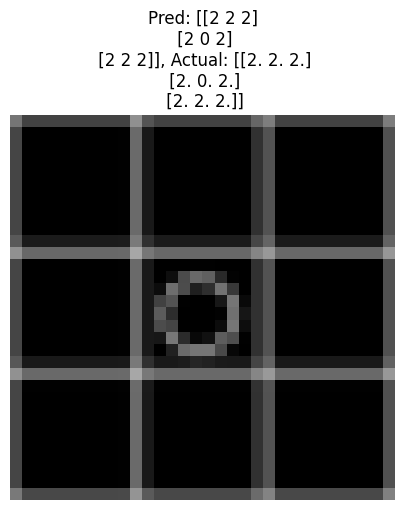

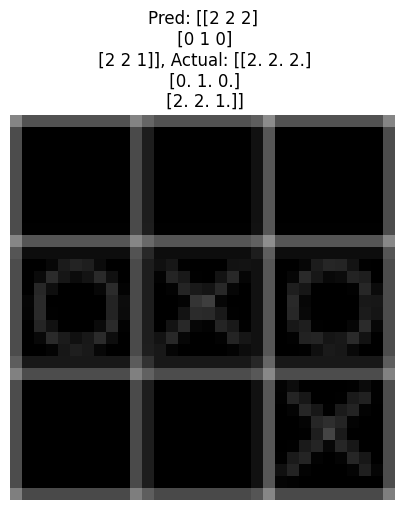

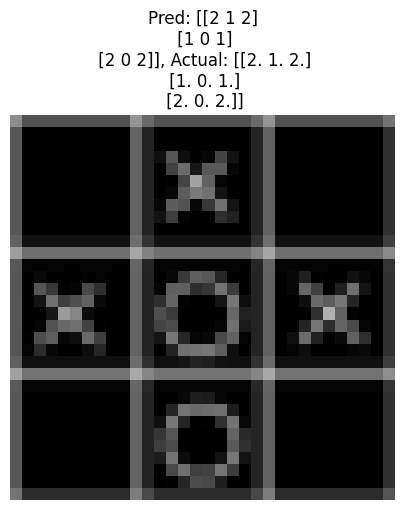

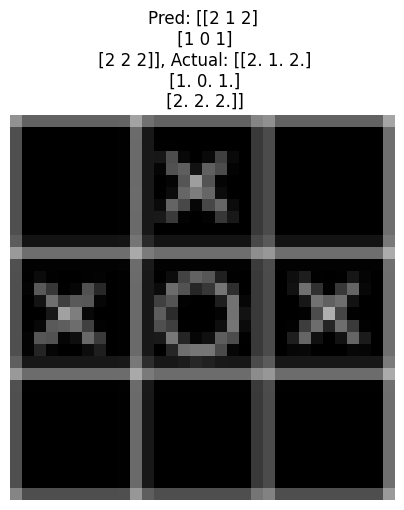

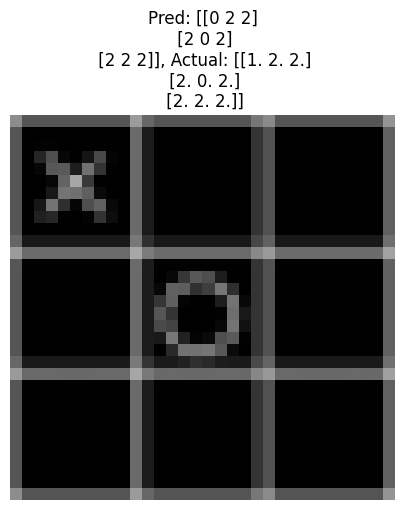

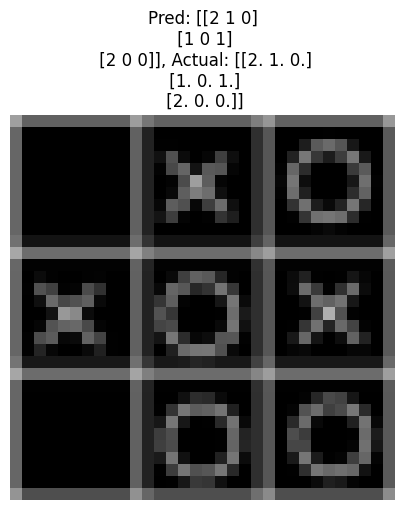

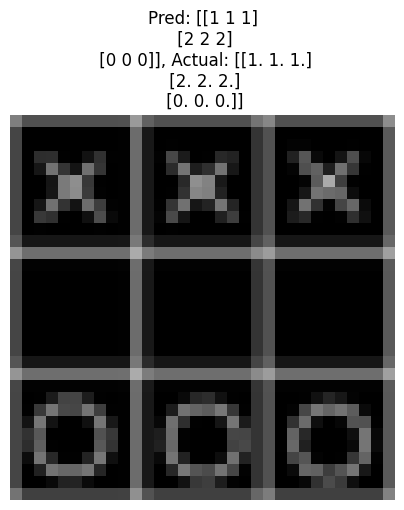

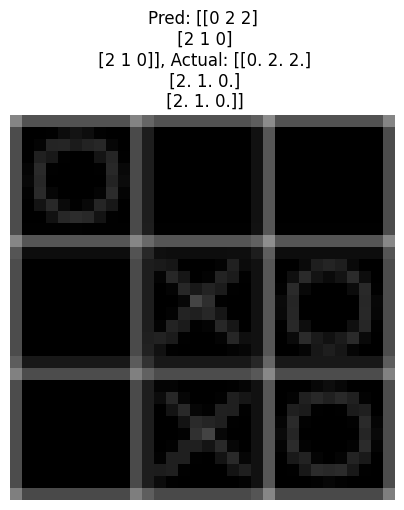

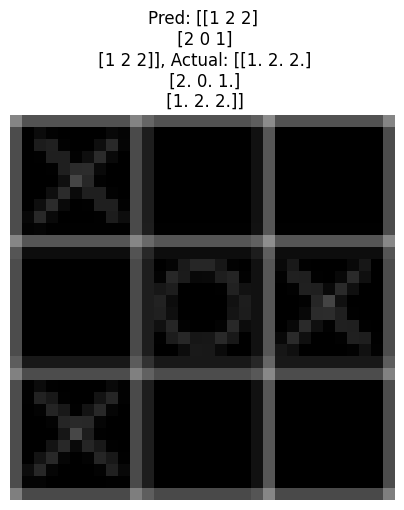

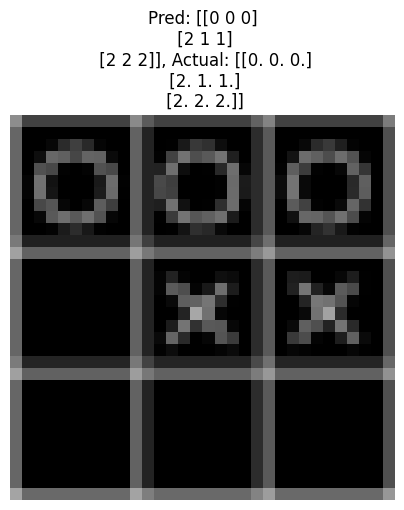

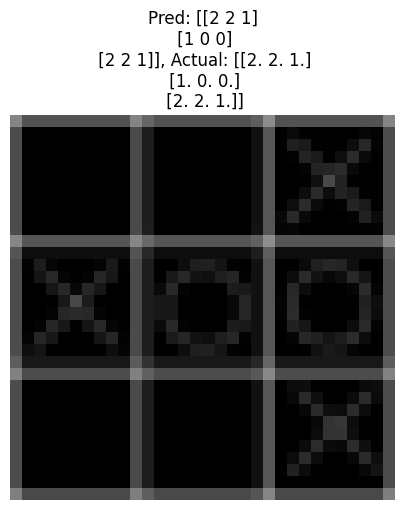

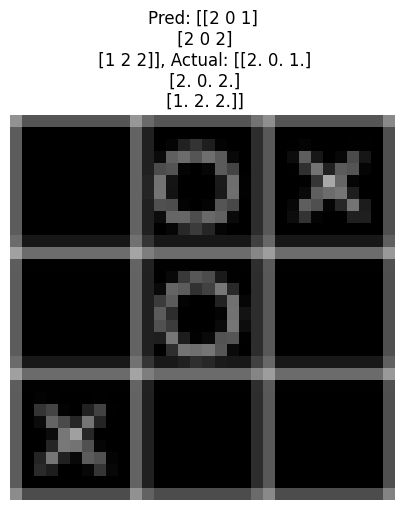

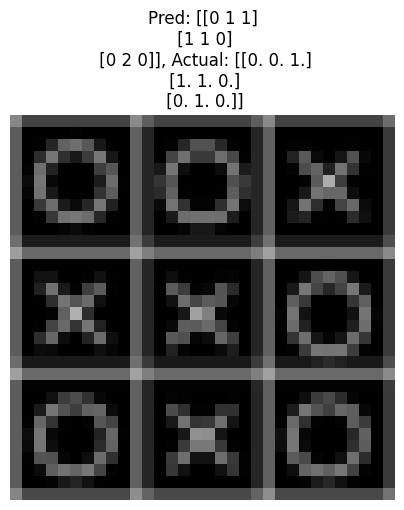

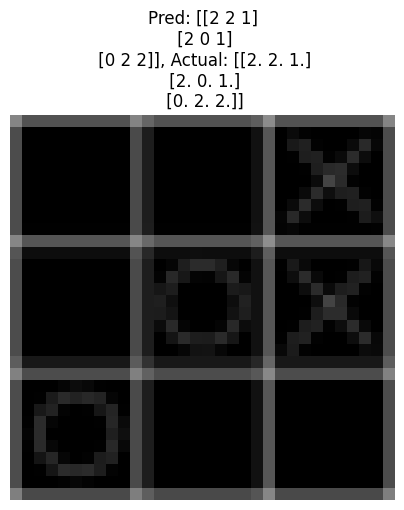

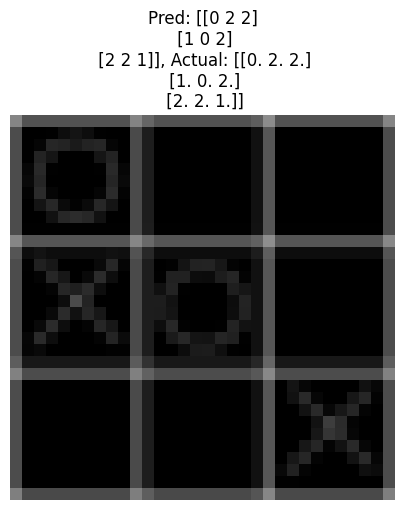

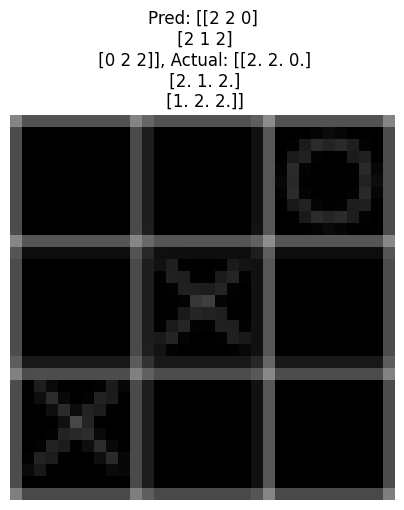

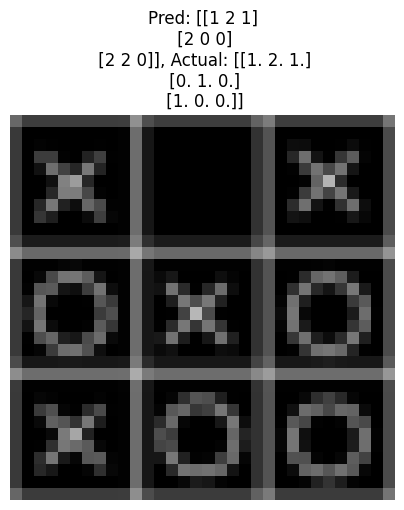

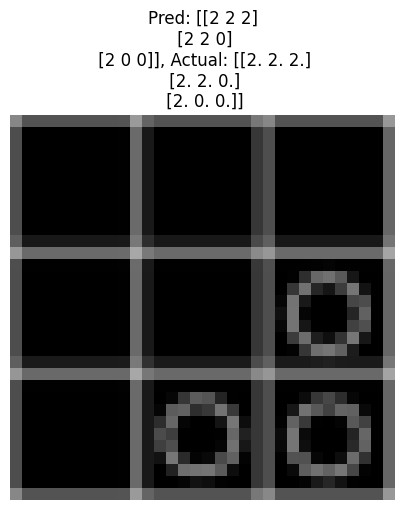

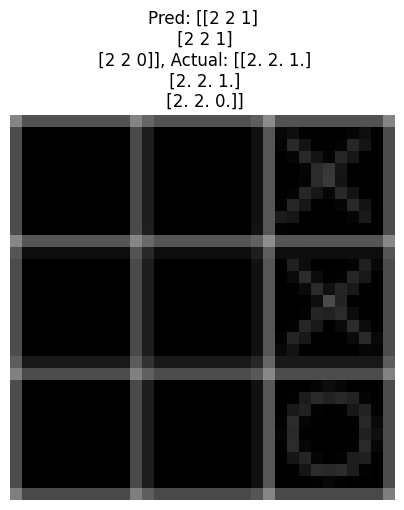

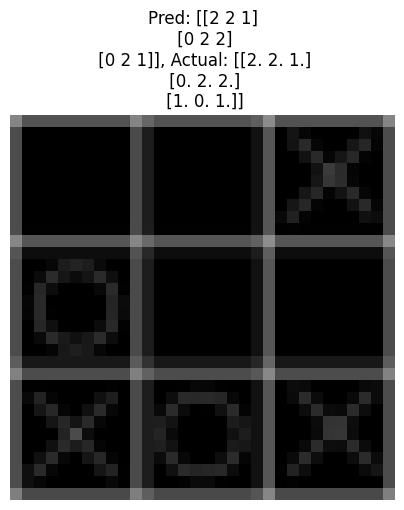

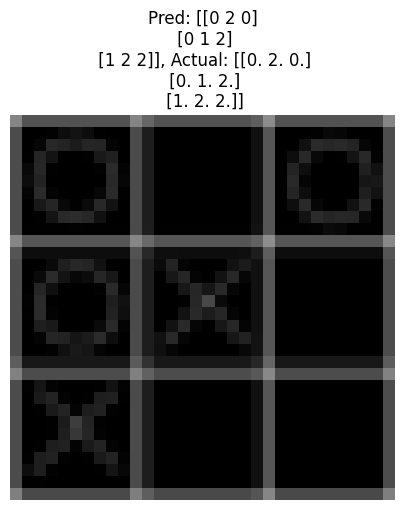

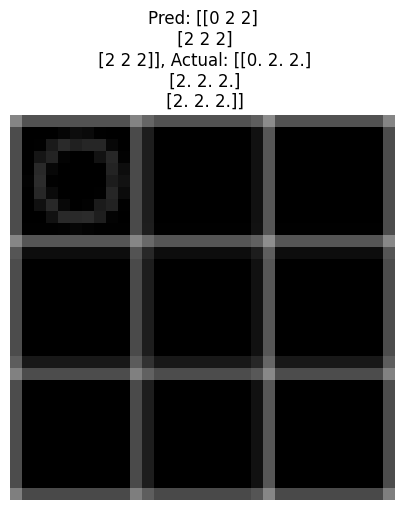

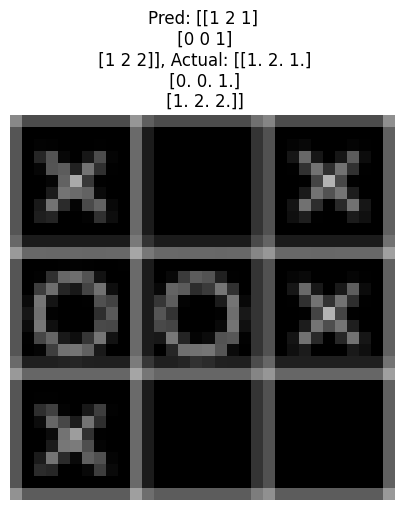

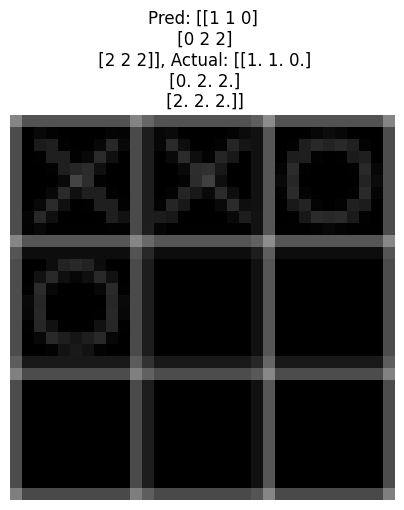

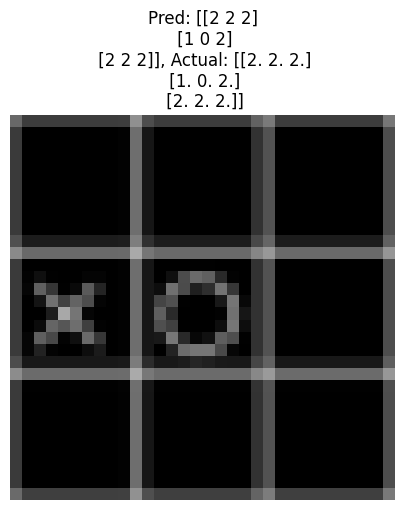

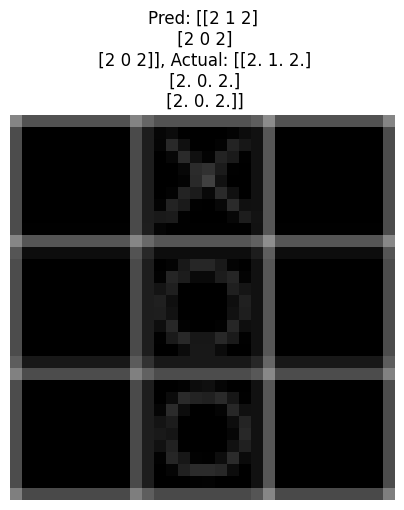

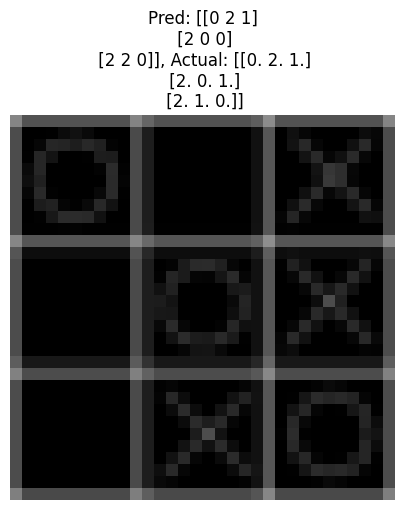

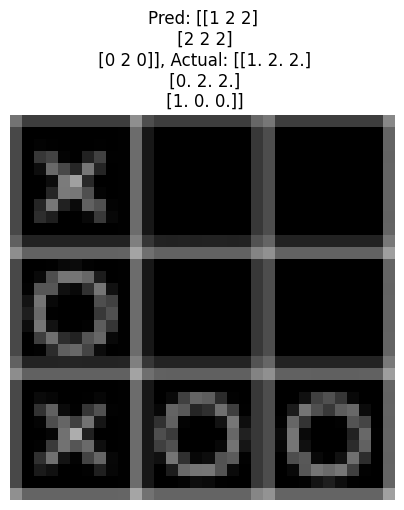

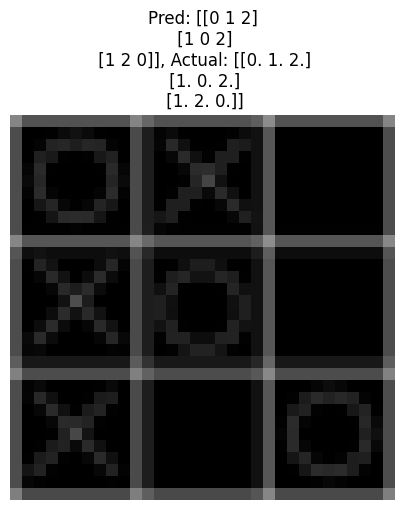

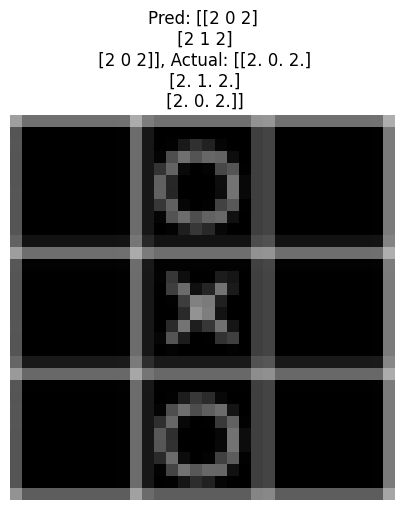

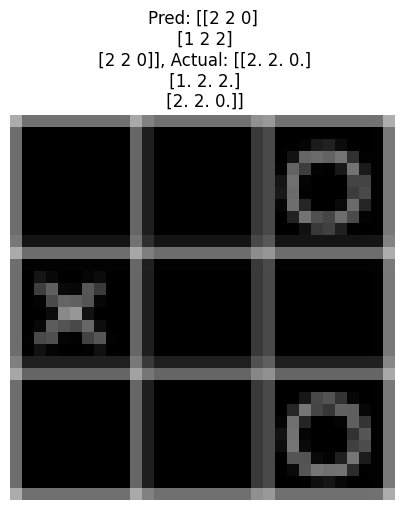

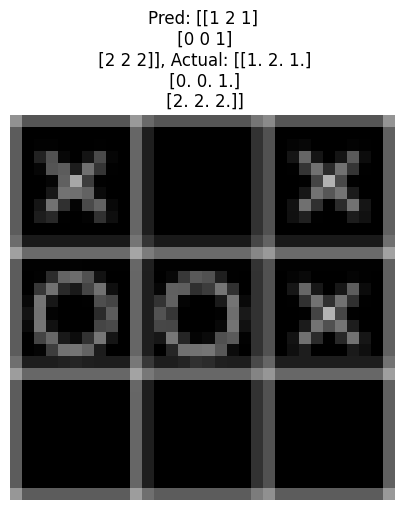

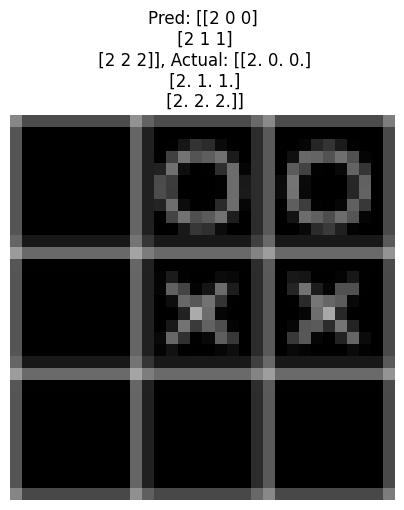

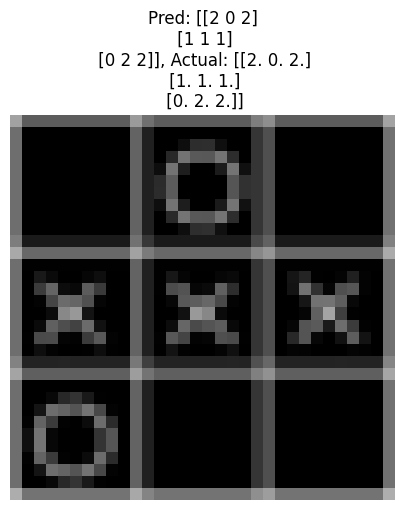

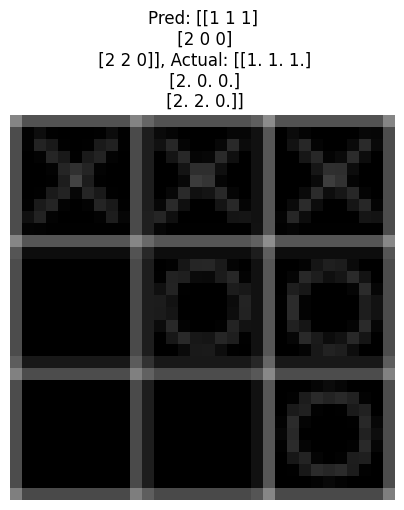

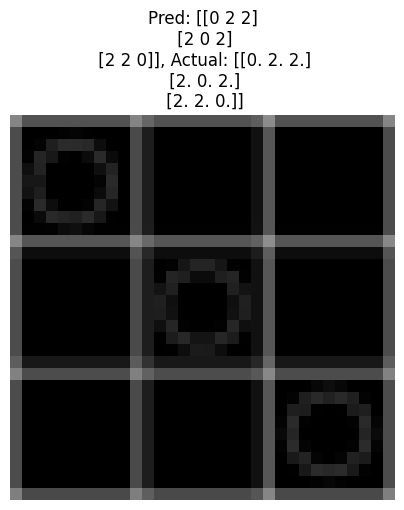

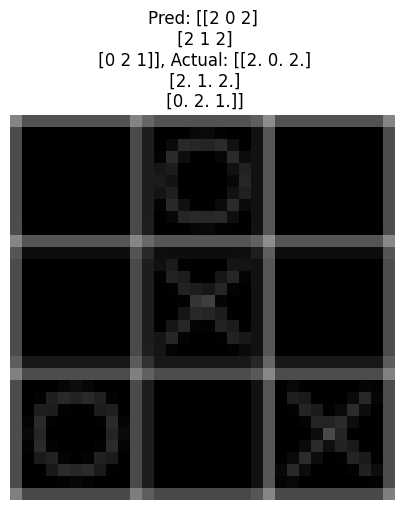

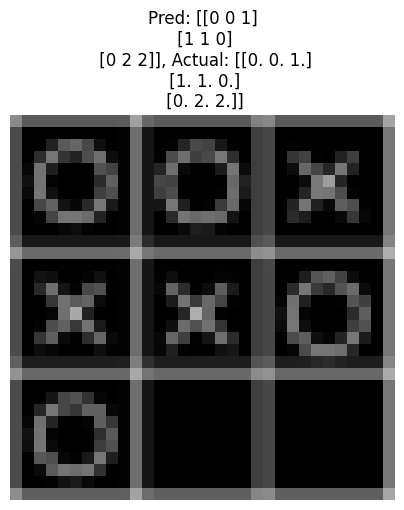

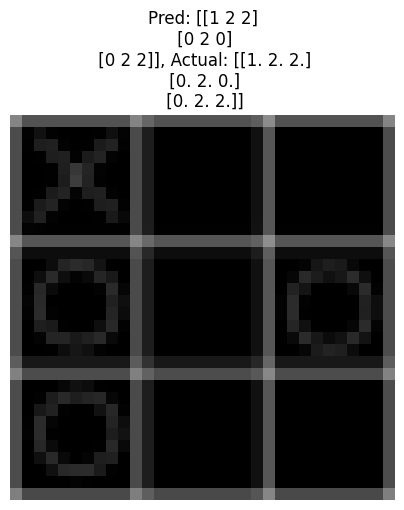

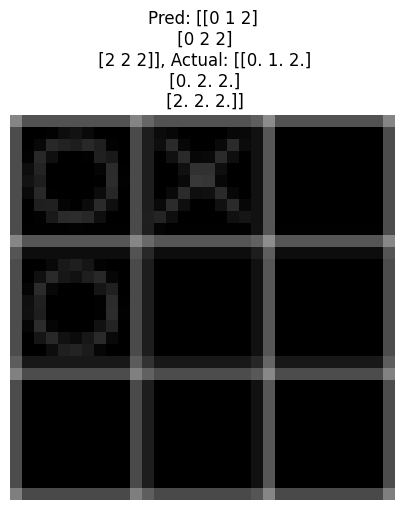

Test Accuracy: 95.83%


In [78]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms

# 모델을 평가 모드로 전환
model.eval()

# 테스트 데이터셋을 위한 변환 설정 (이미지 전처리)
transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
])

# 데이터 로더
test_dataset = TicTacToeCellDataset(image_dir='/content/my_images/image_black', label_dir='/content/my_labels/labels', transform=transform)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


# 테스트 루프
correct = 0
total = 0

with torch.no_grad():  # 평가 모드에서는 그래디언트를 계산하지 않음
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # 모델 예측
        outputs = model(inputs)  # (batch_size, 9, 3)

        # 각 셀별로 가장 높은 확률의 클래스를 선택
        predicted = torch.argmax(outputs, dim=2)  # (batch_size, 9)

        # 레이블 형식 맞추기
        labels = labels.view(-1, 9)  # (batch_size, 9)

        # 정확도 계산
        total += labels.numel()  # 전체 셀 수 (batch_size * 9)
        correct += (predicted == labels).sum().item()

        # 3x3 형태로 변환
        predicted = predicted.view(-1, 3, 3)  # (batch_size, 3, 3)
        labels = labels.view(-1, 3, 3)        # (batch_size, 3, 3)

        # 시각화: 처음 몇 개의 샘플을 시각화
        for i in range(inputs.size(0)):  # 현재 배치의 이미지 개수만큼 반복
            plt.figure(figsize=(5, 5))
            plt.imshow(inputs[i].cpu().numpy().transpose(1, 2, 0))
            plt.title(f"Pred: {predicted[i].cpu().numpy()}, Actual: {labels[i].cpu().numpy()}")
            plt.axis("off")
            plt.show()

# 정확도 출력
accuracy = 100 * correct / total
print(f"Test Accuracy: {accuracy:.2f}%")